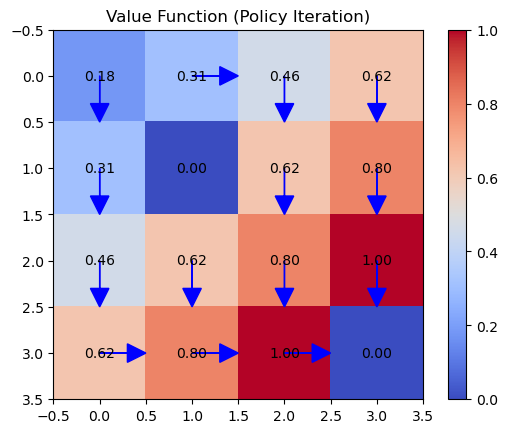

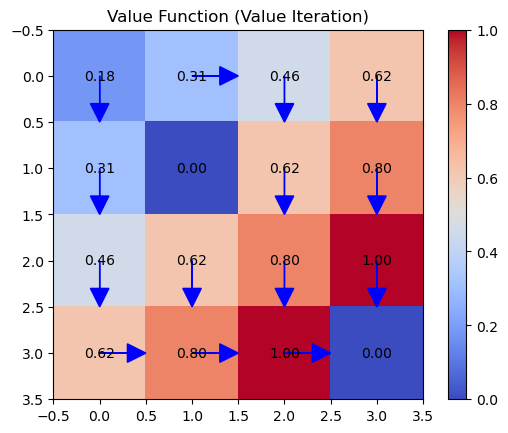

In [3]:
import numpy as np

# Define the grid world MDP
class UpdatedGridMDP:
    def __init__(self, grid_size, goal_state, pit_state, gamma=0.9):
        self.grid_size = grid_size
        self.goal_state = goal_state
        self.pit_state = pit_state
        self.gamma = gamma
        self.actions = ['up', 'down', 'left', 'right']
        self.rewards = np.full(grid_size, -0.1)  # Default reward for each step
        self.rewards[goal_state] = 1  # Goal state reward
        self.rewards[pit_state] = -1  # Pit state penalty
        self.policy = np.ones((grid_size[0], grid_size[1], len(self.actions))) / len(self.actions)

    def get_next_state(self, state, action):
        row, col = state
        if action == 'up': return (max(0, row - 1), col)
        if action == 'down': return (min(self.grid_size[0] - 1, row + 1), col)
        if action == 'left': return (row, max(0, col - 1))
        if action == 'right': return (row, min(self.grid_size[1] - 1, col + 1))

    def is_terminal(self, state):
        return state == self.goal_state or state == self.pit_state

    def get_reward(self, state):
        return self.rewards[state]

# Policy Iteration
def policy_iteration(mdp, theta=0.01):
    V = np.zeros(mdp.grid_size)

    def policy_evaluation(policy, V):
        while True:
            delta = 0
            for row in range(mdp.grid_size[0]):
                for col in range(mdp.grid_size[1]):
                    state = (row, col)
                    if mdp.is_terminal(state): continue
                    v = V[state]
                    new_v = 0
                    for i, action in enumerate(mdp.actions):
                        next_state = mdp.get_next_state(state, action)
                        new_v += policy[row, col, i] * (mdp.get_reward(next_state) + mdp.gamma * V[next_state])
                    V[state] = new_v
                    delta = max(delta, abs(v - V[state]))
            if delta < theta: break
        return V

    def policy_improvement(V):
        new_policy = np.zeros_like(mdp.policy)
        policy_stable = True
        for row in range(mdp.grid_size[0]):
            for col in range(mdp.grid_size[1]):
                state = (row, col)
                if mdp.is_terminal(state): continue
                action_values = []
                for action in mdp.actions:
                    next_state = mdp.get_next_state(state, action)
                    action_values.append(mdp.get_reward(next_state) + mdp.gamma * V[next_state])
                best_action = np.argmax(action_values)
                new_policy[row, col, :] = 0
                new_policy[row, col, best_action] = 1
                if not np.array_equal(new_policy[row, col], mdp.policy[row, col]):
                    policy_stable = False
        return new_policy, policy_stable

    policy_stable = False
    while not policy_stable:
        V = policy_evaluation(mdp.policy, V)
        mdp.policy, policy_stable = policy_improvement(V)
    return V, mdp.policy

# Value Iteration
def value_iteration(mdp, theta=0.01):
    V = np.zeros(mdp.grid_size)
    while True:
        delta = 0
        for row in range(mdp.grid_size[0]):
            for col in range(mdp.grid_size[1]):
                state = (row, col)
                if mdp.is_terminal(state): continue
                action_values = []
                for action in mdp.actions:
                    next_state = mdp.get_next_state(state, action)
                    action_values.append(mdp.get_reward(next_state) + mdp.gamma * V[next_state])
                v = V[state]
                V[state] = max(action_values)
                delta = max(delta, abs(v - V[state]))
        if delta < theta: break

    # Derive the optimal policy from the value function
    optimal_policy = np.zeros_like(mdp.policy)
    for row in range(mdp.grid_size[0]):
        for col in range(mdp.grid_size[1]):
            state = (row, col)
            if mdp.is_terminal(state): continue
            action_values = []
            for action in mdp.actions:
                next_state = mdp.get_next_state(state, action)
                action_values.append(mdp.get_reward(next_state) + mdp.gamma * V[next_state])
            best_action = np.argmax(action_values)
            optimal_policy[row, col, :] = 0
            optimal_policy[row, col, best_action] = 1
    return V, optimal_policy

# Create an MDP instance
grid_size = (4, 4)
goal_state = (3, 3)
pit_state = (1, 1)
mdp = UpdatedGridMDP(grid_size, goal_state, pit_state)

# Run Policy Iteration
V_policy_iter, policy_policy_iter = policy_iteration(mdp)

# Run Value Iteration
V_value_iter, policy_value_iter = value_iteration(mdp)

# Visualize the results
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def visualize_values(values, title="Value Function", policy=None):
    """
    Visualizes the value function or policy over a grid world.

    Args:
    - values (np.ndarray): The value function (2D array of values for each state).
    - title (str): The title of the plot.
    - policy (np.ndarray): (Optional) The policy corresponding to each state, used to overlay arrows.
    """
    fig, ax = plt.subplots()
    ax.imshow(values, cmap="coolwarm", interpolation="none")
    
    # Add the actual values in the grid cells
    for i in range(values.shape[0]):
        for j in range(values.shape[1]):
            ax.text(j, i, f'{values[i, j]:.2f}', ha='center', va='center', color='black')
    
    ax.set_title(title)
    plt.colorbar(ax.imshow(values, cmap="coolwarm"))
    
    # Optionally overlay the policy as arrows
    if policy is not None:
        for i in range(policy.shape[0]):
            for j in range(policy.shape[1]):
                if np.sum(policy[i, j]) == 0:  # Skip terminal states
                    continue
                action = np.argmax(policy[i, j])
                if action == 0:  # Up
                    ax.arrow(j, i, 0, -0.3, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
                elif action == 1:  # Down
                    ax.arrow(j, i, 0, 0.3, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
                elif action == 2:  # Left
                    ax.arrow(j, i, -0.3, 0, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
                elif action == 3:  # Right
                    ax.arrow(j, i, 0.3, 0, head_width=0.2, head_length=0.2, fc='blue', ec='blue')

    plt.show()

# Testing the function with values from Policy Iteration and Value Iteration
visualize_values(V_policy_iter, title="Value Function (Policy Iteration)", policy=policy_policy_iter)
visualize_values(V_value_iter, title="Value Function (Value Iteration)", policy=policy_value_iter)
